In [1]:
# -*- coding: utf-8 -*-
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


Using TensorFlow backend.


## Initialize Variables

In [2]:
v1_numericColumns = ['MIN_PS', 'MAX_PS', 'AVG_PS', 'STD_DEV_PS', 'OCTET_TOTAL_COUNT'
             , 'F_MIN_PS', 'F_MAX_PS', 'F_AVG_PS', 'F_PKT_TOTAL_COUNT', 'F_OCTET_TOTAL_COUNT'
             , 'B_MIN_PS', 'B_MAX_PS', 'B_AVG_PS', 'B_PKT_TOTAL_COUNT', 'B_OCTET_TOTAL_COUNT']


## load model and min-max scaler

load exists autoencoder model and min-max scaler

In [3]:
minMaxScaler = pickle.load(open('../analyze/model/{}'.format('v1_minMaxScalerForDnsFlow-25.02.19_14:48'), 'rb'))
trainedAutoencoder = load_model('../analyze/model/{}'.format('v1_autoencoderForDnsFlow-25.02.19_14:48'))

## Data Pre-processing

In [4]:
malware_datas = pd.read_pickle('../data/dns-malware-flow-25.02.19_11:30.pkl')
normal_datas = pd.read_pickle('../data/dns-flow-25.02.19_14:31.pkl')

In [5]:
malware_datas.describe()

,AVG_PIAT,AVG_PS,B_AVG_PIAT,B_AVG_PS,B_FLOW_DURATION,B_MAX_PIAT,B_MAX_PS,B_MIN_PIAT,B_MIN_PS,B_OCTET_TOTAL_COUNT,...,F_STD_DEV_PIAT,F_STD_DEV_PS,MAX_PIAT,MAX_PS,MIN_PIAT,MIN_PS,OCTET_TOTAL_COUNT,PKT_TOTAL_COUNT,STD_DEV_PIAT,STD_DEV_PS
count,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,...,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000
mean,34.197892,108.167519,101.631613,141.102078,106.833724,103.874271,141.377306,99.448224,140.829591,151.045309,...,2.095888,0.100435,103.884939,141.438252,0.010786,75.070168,231.611468,2.141540,48.492924,33.016084
std,154.473257,4.149088,460.449399,7.760507,485.029141,468.493077,7.808374,456.860778,7.982697,39.677995,...,42.891939,0.495043,468.488452,6.954208,0.020402,2.630220,60.222553,0.553237,218.916713,3.126838
min,0.000000,76.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,76.000000,0.000000,59.000000,76.000000,1.000000,0.000000,0.000000
25%,0.009810,105.500000,0.000000,136.000000,0.000000,0.000000,136.000000,0.000000,136.000000,136.000000,...,0.000000,0.000000,0.009810,136.000000,0.009788,74.000000,211.000000,2.000000,0.000000,30.500000
50%,0.010039,108.000000,0.000000,139.000000,0.000000,0.000000,140.000000,0.000000,139.000000,140.000000,...,0.000000,0.000000,0.010039,140.000000,0.009995,75.000000,217.000000,2.000000,0.000000,31.500000
75%,0.010337,111.500000,0.000000,147.875000,0.000000,0.000000,148.000000,0.000000,147.000000,148.000000,...,0.000000,0.000000,0.010337,148.000000,0.010224,77.000000,223.000000,2.000000,0.000000,36.500000
max,1175.964222,118.500000,3527.882276,167.000000,4222.630837,3527.882276,167.000000,3527.882276,167.000000,583.000000,...,1393.107792,8.000000,3527.872099,167.000000,0.994567,82.000000,887.000000,8.000000,1663.050009,52.500000


In [6]:
normal_datas.describe()

,AVG_PIAT,AVG_PS,B_AVG_PIAT,B_AVG_PS,B_FLOW_DURATION,B_MAX_PIAT,B_MAX_PS,B_MIN_PIAT,B_MIN_PS,B_OCTET_TOTAL_COUNT,...,F_STD_DEV_PIAT,F_STD_DEV_PS,MAX_PIAT,MAX_PS,MIN_PIAT,MIN_PS,OCTET_TOTAL_COUNT,PKT_TOTAL_COUNT,STD_DEV_PIAT,STD_DEV_PS
count,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,...,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000,105035.000000
mean,163.106330,132.553067,454.699485,199.170428,728.466468,543.323975,221.027086,372.177628,178.798458,316.045670,...,82.451637,1.522966,543.876522,221.089237,0.047625,65.829685,420.472347,3.050469,234.809019,70.315583
std,304.907221,49.223156,856.319144,98.872171,1535.630341,1005.014198,118.865434,793.405948,96.252971,302.954965,...,266.108462,3.385720,1005.228614,118.767737,0.103726,8.238477,365.817244,2.009516,433.261900,51.886069
min,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,34.000000,0.000000,34.000000,52.000000,1.000000,0.000000,0.000000
25%,0.022898,96.000000,0.000000,126.000000,0.000000,0.000000,128.000000,0.000000,107.000000,130.000000,...,0.000000,0.000000,0.022918,128.000000,0.016987,61.000000,200.000000,2.000000,0.000000,30.000000
50%,0.039669,121.000000,0.000000,175.333333,0.000000,0.000000,203.000000,0.000000,150.000000,224.000000,...,0.000000,0.000000,0.039690,203.000000,0.025267,64.000000,297.000000,2.000000,0.000000,61.241779
75%,189.893165,156.500000,543.168387,249.000000,647.224691,619.898154,283.000000,199.247762,230.000000,379.000000,...,0.000000,1.500000,623.628840,283.000000,0.037293,70.000000,489.000000,4.000000,281.085288,100.000000
max,1790.303694,375.000000,3599.901488,687.000000,13748.010257,5499.780357,725.000000,3599.901488,687.000000,4415.000000,...,1798.965481,51.000000,3599.977986,725.000000,4.861821,176.000000,5398.000000,34.000000,1790.291211,312.000000


In [7]:
malware_datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 39 columns):
AVG_PIAT               2494 non-null float64
AVG_PS                 2494 non-null float64
B_AVG_PIAT             2494 non-null float64
B_AVG_PS               2494 non-null float64
B_FLOW_DURATION        2494 non-null float64
B_MAX_PIAT             2494 non-null float64
B_MAX_PS               2494 non-null float64
B_MIN_PIAT             2494 non-null float64
B_MIN_PS               2494 non-null float64
B_OCTET_TOTAL_COUNT    2494 non-null float64
B_PKT_TOTAL_COUNT      2494 non-null float64
B_STD_DEV_PIAT         2494 non-null float64
B_STD_DEV_PS           2494 non-null float64
DST_IP                 2494 non-null object
DST_PORT               2494 non-null object
FLOW_DURATION          2494 non-null float64
F_AVG_PIAT             2494 non-null float64
F_AVG_PS               2494 non-null float64
F_FLOW_DURATION        2494 non-null float64
F_MAX_PIAT             2494 non-null flo

In [8]:
normal_datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105035 entries, 0 to 105034
Data columns (total 39 columns):
AVG_PIAT               105035 non-null float64
AVG_PS                 105035 non-null float64
B_AVG_PIAT             105035 non-null float64
B_AVG_PS               105035 non-null float64
B_FLOW_DURATION        105035 non-null float64
B_MAX_PIAT             105035 non-null float64
B_MAX_PS               105035 non-null float64
B_MIN_PIAT             105035 non-null float64
B_MIN_PS               105035 non-null float64
B_OCTET_TOTAL_COUNT    105035 non-null float64
B_PKT_TOTAL_COUNT      105035 non-null float64
B_STD_DEV_PIAT         105035 non-null float64
B_STD_DEV_PS           105035 non-null float64
DST_IP                 105035 non-null object
DST_PORT               105035 non-null object
FLOW_DURATION          105035 non-null float64
F_AVG_PIAT             105035 non-null float64
F_AVG_PS               105035 non-null float64
F_FLOW_DURATION        105035 non-null float6

In [9]:
malware_datas['IS_MALWARE'] = 'Y'

In [10]:
normal_datas['IS_MALWARE'] = 'N'

In [11]:
datas = pd.concat([malware_datas, normal_datas], ignore_index=True)

In [12]:
datas.info()
# normal : 100,000
# malware : 2,000
# Q1. Do we need to equalize the number of flow at the same count?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107529 entries, 0 to 107528
Data columns (total 40 columns):
AVG_PIAT               107529 non-null float64
AVG_PS                 107529 non-null float64
B_AVG_PIAT             107529 non-null float64
B_AVG_PS               107529 non-null float64
B_FLOW_DURATION        107529 non-null float64
B_MAX_PIAT             107529 non-null float64
B_MAX_PS               107529 non-null float64
B_MIN_PIAT             107529 non-null float64
B_MIN_PS               107529 non-null float64
B_OCTET_TOTAL_COUNT    107529 non-null float64
B_PKT_TOTAL_COUNT      107529 non-null float64
B_STD_DEV_PIAT         107529 non-null float64
B_STD_DEV_PS           107529 non-null float64
DST_IP                 107529 non-null object
DST_PORT               107529 non-null object
FLOW_DURATION          107529 non-null float64
F_AVG_PIAT             107529 non-null float64
F_AVG_PS               107529 non-null float64
F_FLOW_DURATION        107529 non-null float6

In [13]:
min_max_scaled_datas = minMaxScaler.fit_transform(datas[v1_numericColumns])

In [14]:
original_datas = datas.copy()

In [15]:
datas[v1_numericColumns] = min_max_scaled_datas

In [16]:
min_max_scaled_datas

array([[0.31690141, 0.15484805, 0.2228739 , ..., 0.20524017, 0.0625    ,
        0.03193658],
       [0.31690141, 0.15340087, 0.22140762, ..., 0.20378457, 0.0625    ,
        0.03171008],
       [0.29577465, 0.14905933, 0.21260997, ..., 0.19941776, 0.0625    ,
        0.03103058],
       ...,
       [0.14084507, 0.29088278, 0.32404692, ..., 0.34206696, 0.0625    ,
        0.05322763],
       [0.00704225, 0.08827786, 0.09090909, ..., 0.13828239, 0.0625    ,
        0.02151755],
       [0.00704225, 0.10564399, 0.1085044 , ..., 0.15574964, 0.0625    ,
        0.02423556]])

In [17]:
datas.describe()

,AVG_PIAT,AVG_PS,B_AVG_PIAT,B_AVG_PS,B_FLOW_DURATION,B_MAX_PIAT,B_MAX_PS,B_MIN_PIAT,B_MIN_PS,B_OCTET_TOTAL_COUNT,...,F_STD_DEV_PIAT,F_STD_DEV_PS,MAX_PIAT,MAX_PS,MIN_PIAT,MIN_PS,OCTET_TOTAL_COUNT,PKT_TOTAL_COUNT,STD_DEV_PIAT,STD_DEV_PS
count,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,...,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000
mean,160.116461,0.287353,446.510519,0.287953,714.048478,533.131492,0.302317,365.852012,0.258978,0.070718,...,80.587886,1.489972,533.671470,0.268078,0.046771,0.225662,0.068105,3.029387,230.487652,0.222598
std,302.889127,0.143083,850.890383,0.142818,1522.391089,998.043255,0.162890,788.300000,0.138733,0.068066,...,263.363261,3.353916,998.259518,0.170764,0.102713,0.058240,0.067860,1.992563,430.417921,0.165351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.022127,0.184751,0.000000,0.184498,0.000000,0.000000,0.177931,0.000000,0.158661,0.029445,...,0.000000,0.000000,0.022139,0.137482,0.016402,0.190141,0.027684,2.000000,0.000000,0.096154
50%,0.038522,0.250733,0.000000,0.248908,0.000000,0.000000,0.266207,0.000000,0.215429,0.050057,...,0.000000,0.000000,0.038541,0.230101,0.024851,0.218310,0.044893,2.000000,0.000000,0.186400
75%,172.062392,0.355572,494.433291,0.358079,581.833126,559.319280,0.384828,173.410076,0.331878,0.084938,...,0.000000,1.479020,562.977237,0.354559,0.036830,0.253521,0.080621,4.000000,253.220824,0.315705
max,1790.303694,1.000000,3599.901488,1.000000,13748.010257,5499.780357,1.000000,3599.901488,1.000000,1.000000,...,1798.965481,51.000000,3599.977986,1.000000,4.861821,1.000000,1.000000,34.000000,1790.291211,1.000000


## Analyze

by using predict_x and original x, let's figure out which feature has more important weight in auto encoder

In [18]:
datas = sklearn.utils.shuffle(datas)

In [19]:
datas['idx'] = np.arange(len(datas))
datas_pred = datas.copy()

In [20]:
datas_pred[v1_numericColumns] = trainedAutoencoder.predict(datas[v1_numericColumns])

In [21]:
datas_compare = datas.copy()

In [22]:
datas_compare[v1_numericColumns] = datas[v1_numericColumns] - datas_pred[v1_numericColumns]

In [23]:
datas_compare['SUM'] = datas_compare[v1_numericColumns].sum(axis=1)

In [24]:
datas_compare['MEAN'] = np.square(datas_compare[v1_numericColumns].mean(axis=1))

In [25]:
datas_compare[v1_numericColumns].head(10)

,MIN_PS,MAX_PS,AVG_PS,STD_DEV_PS,OCTET_TOTAL_COUNT,F_MIN_PS,F_MAX_PS,F_AVG_PS,F_PKT_TOTAL_COUNT,F_OCTET_TOTAL_COUNT,B_MIN_PS,B_MAX_PS,B_AVG_PS,B_PKT_TOTAL_COUNT,B_OCTET_TOTAL_COUNT
66995,-0.004300,-0.003979,0.003750,0.001127,0.000151,-0.004245,0.013469,0.008874,-0.003926,-0.000948,0.005274,-0.003610,-0.001885,-0.000107,-0.000161
8702,0.002491,0.001425,-0.002157,0.003247,0.000851,0.002577,-0.005267,-0.001845,-0.003603,-0.004813,-0.007940,0.000389,-0.005413,0.004767,-0.000482
83937,-0.004725,-0.005418,-0.006538,0.003575,0.000409,-0.004553,-0.001838,-0.000917,-0.001769,-0.000905,-0.013809,-0.006740,-0.010466,0.003695,-0.000117
23760,-0.001094,-0.004704,0.010882,-0.003241,0.004387,-0.001018,-0.012111,-0.005661,-0.001438,-0.001766,0.001944,-0.005974,0.002508,0.002106,0.005892
89032,0.004181,0.058756,-0.190806,-0.001736,-0.039211,0.004321,0.012705,0.008411,0.095723,0.097813,0.054698,0.054892,0.052941,-0.066036,-0.071870
9232,0.001152,0.007617,0.003572,0.006129,0.001241,0.001251,-0.002558,-0.001132,-0.009873,-0.010882,-0.009147,0.004305,-0.003653,0.002973,-0.000292
89504,-0.006534,0.002472,-0.005677,0.007759,0.000901,-0.006395,-0.007163,-0.004042,-0.002011,-0.001470,-0.005275,0.000822,-0.002628,0.001936,0.002286
73746,0.002502,-0.001038,0.000575,-0.000280,0.004778,0.002623,0.001158,0.004153,-0.001286,0.000632,-0.010036,-0.003616,-0.007601,0.004656,0.003228
9411,-0.002914,0.007357,-0.003001,-0.011176,0.005178,-0.002857,-0.002812,-0.002566,0.006928,0.004257,0.005291,0.005741,-0.009870,0.012808,0.003985
66645,0.000984,-0.003270,0.000767,-0.006084,-0.001252,0.001049,-0.006244,-0.003480,-0.010575,-0.011385,-0.007733,-0.002928,-0.007443,0.002560,-0.000727


/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


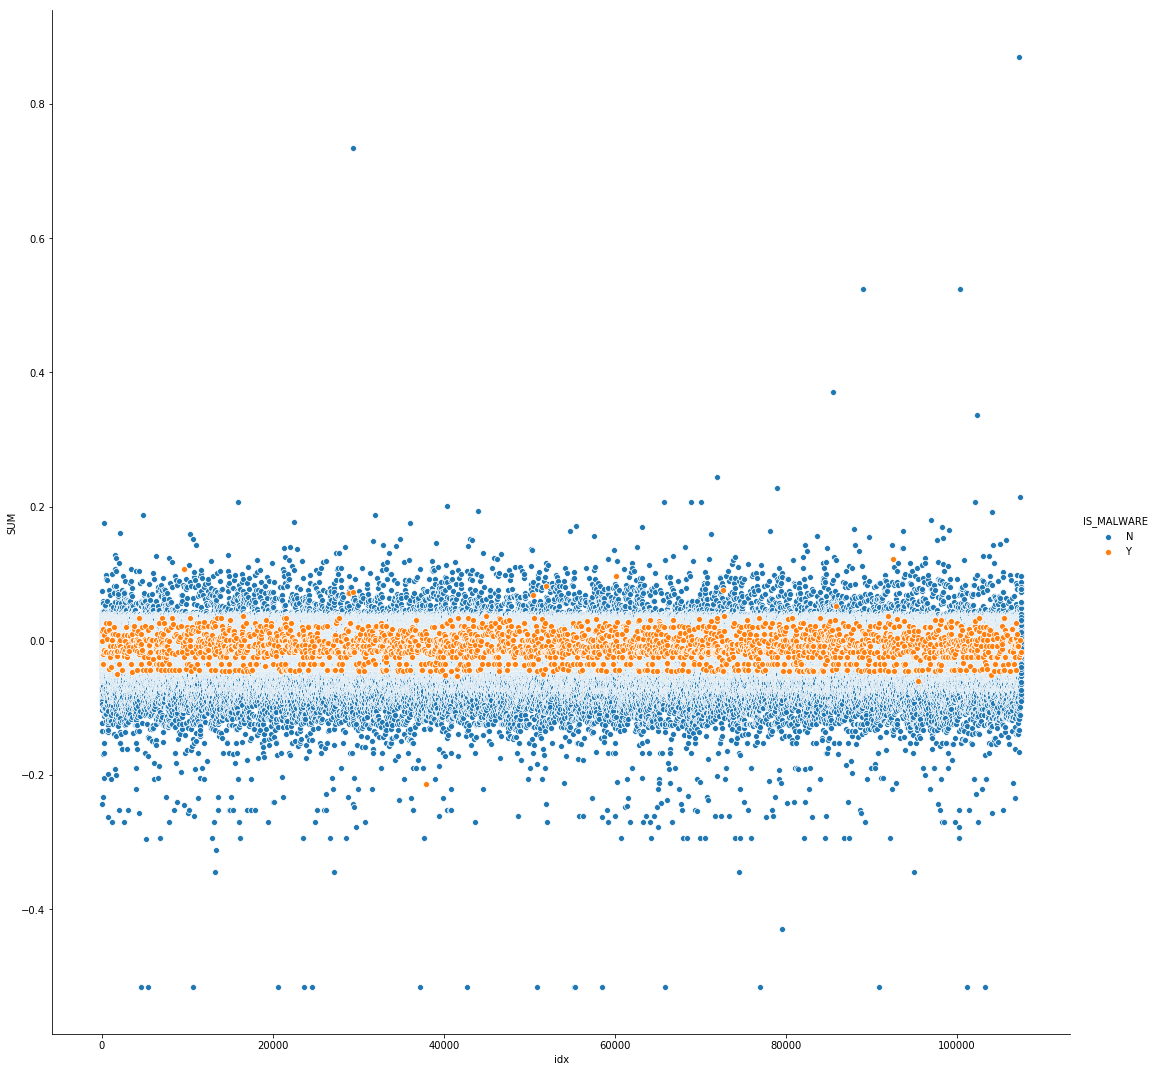

In [26]:
sns.pairplot(x_vars=["idx"], y_vars=["SUM"], data=datas_compare, hue="IS_MALWARE", size=15)

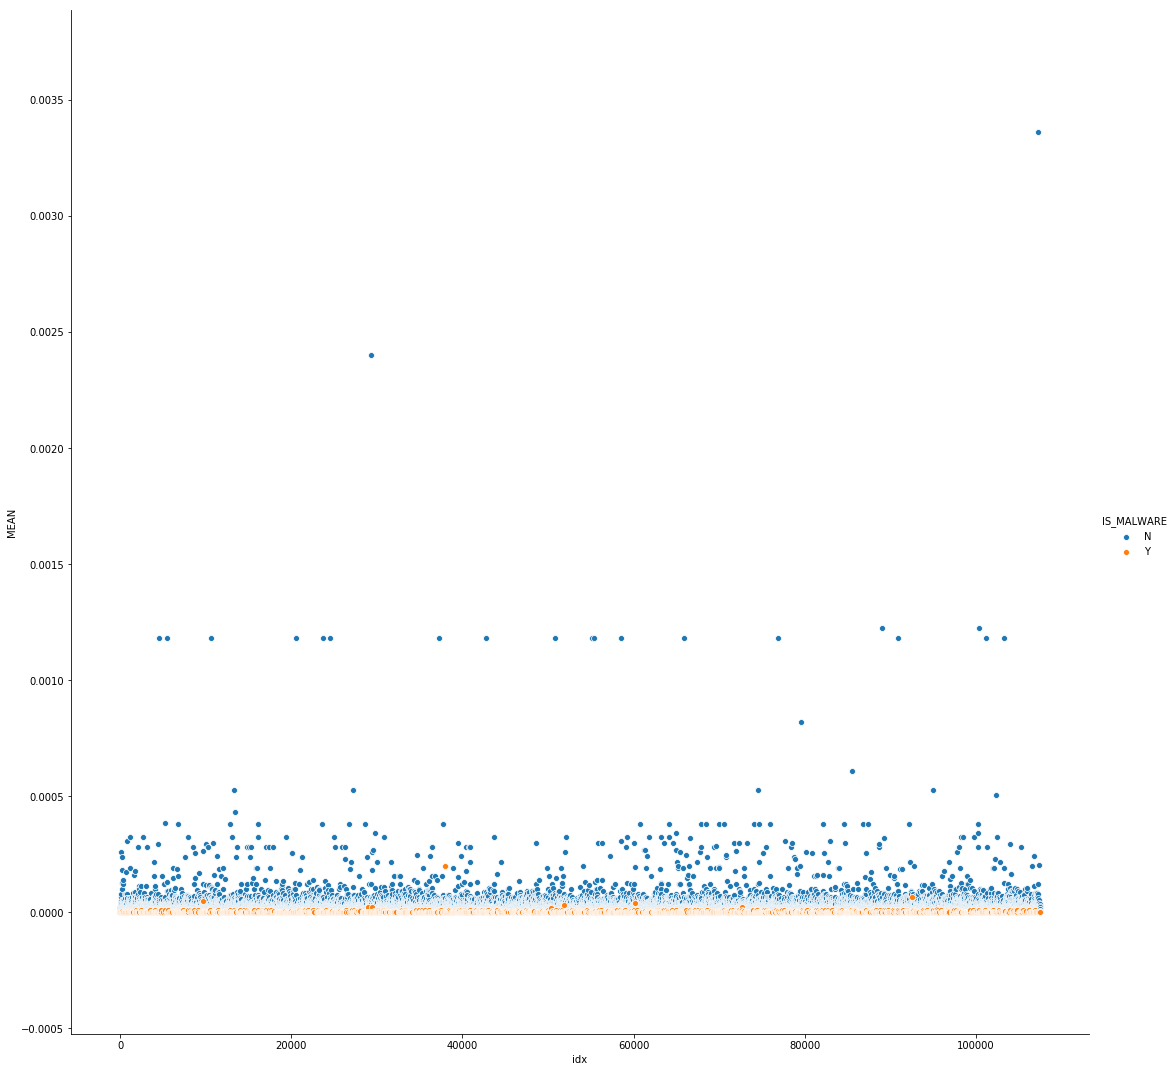

In [27]:
sns.pairplot(x_vars=["idx"], y_vars=["MEAN"], data=datas_compare, hue="IS_MALWARE", size=15)

In [28]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107529 entries, 66995 to 53711
Data columns (total 41 columns):
AVG_PIAT               107529 non-null float64
AVG_PS                 107529 non-null float64
B_AVG_PIAT             107529 non-null float64
B_AVG_PS               107529 non-null float64
B_FLOW_DURATION        107529 non-null float64
B_MAX_PIAT             107529 non-null float64
B_MAX_PS               107529 non-null float64
B_MIN_PIAT             107529 non-null float64
B_MIN_PS               107529 non-null float64
B_OCTET_TOTAL_COUNT    107529 non-null float64
B_PKT_TOTAL_COUNT      107529 non-null float64
B_STD_DEV_PIAT         107529 non-null float64
B_STD_DEV_PS           107529 non-null float64
DST_IP                 107529 non-null object
DST_PORT               107529 non-null object
FLOW_DURATION          107529 non-null float64
F_AVG_PIAT             107529 non-null float64
F_AVG_PS               107529 non-null float64
F_FLOW_DURATION        107529 non-null flo

In [29]:
datas[v1_numericColumns].describe()

,MIN_PS,MAX_PS,AVG_PS,STD_DEV_PS,OCTET_TOTAL_COUNT,F_MIN_PS,F_MAX_PS,F_AVG_PS,F_PKT_TOTAL_COUNT,F_OCTET_TOTAL_COUNT,B_MIN_PS,B_MAX_PS,B_AVG_PS,B_PKT_TOTAL_COUNT,B_OCTET_TOTAL_COUNT
count,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000
mean,0.225662,0.268078,0.287353,0.222598,0.068105,0.225662,0.248950,0.236645,0.031565,0.058034,0.258978,0.302317,0.287953,0.093299,0.070718
std,0.058240,0.170764,0.143083,0.165351,0.067860,0.058240,0.068368,0.057120,0.062059,0.059933,0.138733,0.162890,0.142818,0.059917,0.068066
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.190141,0.137482,0.184751,0.096154,0.027684,0.190141,0.204225,0.197183,0.000000,0.024917,0.158661,0.177931,0.184498,0.062500,0.029445
50%,0.218310,0.230101,0.250733,0.186400,0.044893,0.218310,0.239437,0.232394,0.000000,0.030731,0.215429,0.266207,0.248908,0.062500,0.050057
75%,0.253521,0.354559,0.355572,0.315705,0.080621,0.253521,0.274648,0.264085,0.058824,0.078904,0.331878,0.384828,0.358079,0.125000,0.084938
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
datas_pred[v1_numericColumns].describe()

,MIN_PS,MAX_PS,AVG_PS,STD_DEV_PS,OCTET_TOTAL_COUNT,F_MIN_PS,F_MAX_PS,F_AVG_PS,F_PKT_TOTAL_COUNT,F_OCTET_TOTAL_COUNT,B_MIN_PS,B_MAX_PS,B_AVG_PS,B_PKT_TOTAL_COUNT,B_OCTET_TOTAL_COUNT
count,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000
mean,0.226106,0.269597,0.289587,0.224711,0.067841,0.226009,0.250634,0.235035,0.032930,0.058676,0.262569,0.303835,0.290811,0.091916,0.070280
std,0.057954,0.171360,0.142710,0.165502,0.067900,0.057936,0.068381,0.056681,0.061784,0.059820,0.139441,0.163349,0.143757,0.059131,0.068337
min,0.072086,0.038600,0.062208,0.014816,0.006534,0.072035,0.075582,0.071865,0.000038,0.007487,0.022550,0.073430,0.070420,0.034108,0.006919
25%,0.188749,0.131977,0.180971,0.088002,0.027570,0.188688,0.203903,0.194538,0.001179,0.024327,0.159087,0.174421,0.181396,0.061019,0.027896
50%,0.215283,0.237733,0.257771,0.201469,0.044679,0.215218,0.241445,0.227785,0.001497,0.031576,0.216950,0.271555,0.257517,0.062395,0.049135
75%,0.252417,0.351939,0.355161,0.310740,0.081468,0.252315,0.276076,0.262144,0.063552,0.081618,0.331542,0.383844,0.358266,0.122208,0.085287
max,0.866509,0.876273,0.845960,0.874206,0.873567,0.863269,0.858347,0.848551,0.851009,0.875447,0.828079,0.874976,0.855717,0.812933,0.860621


In [31]:
len(datas.columns)

41

In [46]:
from keras import backend as K

def root_mean_squared_error(x, x_pred):
    return ((x - x_pred) ** 2).mean() ** .5
#         return np.roots(np.sum((x - x_pred)**2, axis=1).mean())

In [47]:
rslt = root_mean_squared_error(datas[v1_numericColumns], datas_pred[v1_numericColumns])

ValueError: No axis named 1 for object type <class 'type'>

In [48]:
rslt

array([], dtype=float64)

In [45]:
datas_compare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107529 entries, 66995 to 53711
Data columns (total 43 columns):
AVG_PIAT               107529 non-null float64
AVG_PS                 107529 non-null float64
B_AVG_PIAT             107529 non-null float64
B_AVG_PS               107529 non-null float64
B_FLOW_DURATION        107529 non-null float64
B_MAX_PIAT             107529 non-null float64
B_MAX_PS               107529 non-null float64
B_MIN_PIAT             107529 non-null float64
B_MIN_PS               107529 non-null float64
B_OCTET_TOTAL_COUNT    107529 non-null float64
B_PKT_TOTAL_COUNT      107529 non-null float64
B_STD_DEV_PIAT         107529 non-null float64
B_STD_DEV_PS           107529 non-null float64
DST_IP                 107529 non-null object
DST_PORT               107529 non-null object
FLOW_DURATION          107529 non-null float64
F_AVG_PIAT             107529 non-null float64
F_AVG_PS               107529 non-null float64
F_FLOW_DURATION        107529 non-null flo